In [1]:
from collections import defaultdict

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from astropy.modeling import models

In [2]:
# makes the "random" numbers reproducible
np.random.seed(12345)

# Testing fit uncertainties 

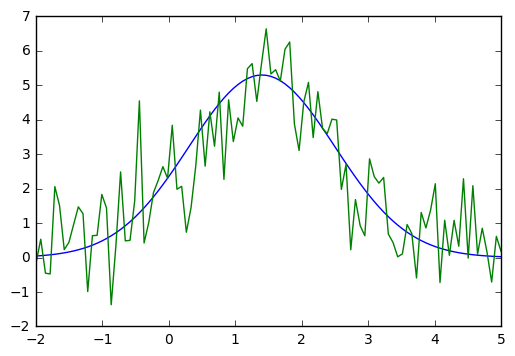

In [3]:
gauss = models.Gaussian1D(amplitude=5.3, mean=1.4, stddev=1.1)
x = np.linspace(-2, 5, 100)

base_data = gauss(x)
data_random = np.random.normal(0, 1, x.shape)
data = base_data + data_random
plt.plot(x, base_data)
plt.plot(x, data)

In [4]:
from astropy.modeling import fitting

In [5]:
fitter = fitting.LevMarLSQFitter()
model = fitter(gauss, x, data)

## Covariance in the  LevMarLSQFitter

The below is the parameter covariance matrix that `LevMarLSQFitter` generates. Most of the other fitters don't report uncertainties, but the Levenberg-Marquardt algorithms is such that it's relatively straightforward to have it come out without additional computational expense.

In [6]:
cov = fitter.fit_info['param_cov']
cov

array([[  5.68024914e-02,   1.11636496e-06,  -8.64051873e-03],
       [  1.11636496e-06,   3.93137225e-03,  -5.70164087e-07],
       [ -8.64051873e-03,  -5.70164087e-07,   3.93869884e-03]])

So then $\sqrt{{\rm diag}(cov)}$ is the uncertainties on the parameters:

In [7]:
dict(zip(model.param_names, np.diag(cov)**0.5))

{'amplitude': 0.2383327325763821,
 'mean': 0.062700655905525871,
 'stddev': 0.062759053809748763}

Now lets just try making two models like the original model, but with the parameters for the + and - sides of the uncertainties, and show those models over the original data:

In [8]:
modelup = model.copy()
modeldown = model.copy()

for i, nm in enumerate(model.param_names):
    setattr(modelup, nm, getattr(model, nm) + fitter.fit_info['param_cov'][i, i]**0.5)
    setattr(modeldown, nm, getattr(model, nm) - fitter.fit_info['param_cov'][i, i]**0.5)

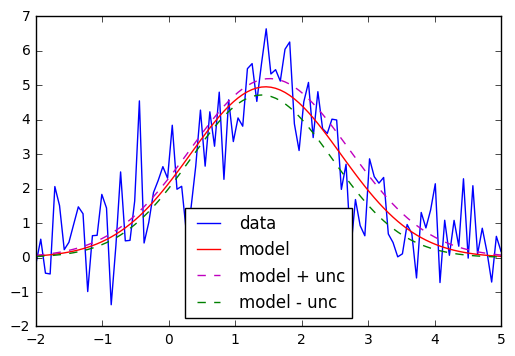

In [9]:
plt.plot(x, data, label='data')
plt.plot(x, model(x), 'r', label='model')
plt.plot(x, modelup(x), 'm', ls='--', label='model + unc')
plt.plot(x, modeldown(x), 'g', ls='--', label='model - unc')
plt.legend(loc=0)

## Monte Carlo Uncertainties 

A completely different way to do uncertainties is to do Monte Carlo realizations of the spectrum and fit a bunch of those.  The below does exactly this, and then plot the distributions.  The width of those distributions then encode the uncertainties in the fit.

In [10]:
dists = defaultdict(list)
for i in range(1000):
    # create a data set that is the base data, but with a random offset that's scaled
    # to match the uncertainties we used to create the data in the first place
    unc = np.std(data_random)
    yoff = data + np.random.randn(len(data)) * unc
    
    # make a temporary fit that we just discard at the end of this loop,
    # having extracted the parameter values
    modeli = fitter(gauss, x, yoff)
    for nm in modeli.param_names:
        dists[nm].append(getattr(modeli, nm).value)
        
dists = {k: np.array(v) for k,v in dists.items()}

The Cell below produces an expected error unless you also install corner

In [11]:
# you'll need to "pip install corner" to get the plot below
import corner

distarr = np.array([dists[nm] for nm in model.param_names]).T

corner.corner(distarr, labels=model.param_names, show_titles=True, title_fmt='.3f', truths=model.parameters)
print('LevMar fitter uncertainties:\n', np.sign(cov)*np.abs(cov)**0.5)

ImportError: No module named 'corner'

Comparing the diagonals of the covariance matrix to the uncertainties the corner plot shows demonstrates that they are quite consistent: the `mean` is very close, while for `amplitude` and `stddev` they are fairly close, but not quite the same, primarily due to a larger covariance between the parameters.

# Chi-squared

To compute the chi-squared we can just do so directly, using:

$ \chi^2 = \sum_{i}\frac{(O_i-E_i)^2}{\sigma^2}$

In this case, $O_i$ is the actual data, and $E_i$ are the model's outputs, and \sigma^2 is the variance (could be per-pixel but in this case we assumed uniform).

In [12]:
dof = len(data) - len(model.parameters)
unc = 1 # this is the amplitude of data_random, so we know the *true* uncertainty in each pixel

Below we show the *reduced* chi-squared, as that's what we can use to actually compare fits.

In [13]:
Oi = data
Ei = model(x)
chisq = np.sum((Oi - Ei)**2 / unc)
chisq / dof

1.0717686317063173

Seems promising... Now lets make sure the one-sigma-up and one-sigma-down are worse fits:

In [14]:
Oi = data
Ei = modelup(x)
chisq = np.sum((Oi - Ei)**2 / unc)
chisq / dof

1.1350310771395113

In [15]:
Oi = data
Ei = modeldown(x)
chisq = np.sum((Oi - Ei)**2 / unc)
chisq / dof

1.132821998907509

Hooray!  Statistics kind of makes sense after all!